In [1]:
from lab3_tools import *
import numpy as np

In [2]:
path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

('man', 'ae', 'z9z6531', 'a')

In [3]:
loadAudio('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

(array([11, 13, 11, ...,  9,  9,  9], dtype=int16), 20000)

In [4]:
phoneHMMs = np.load('../lab2/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
stateList

['ah_0',
 'ah_1',
 'ah_2',
 'ao_0',
 'ao_1',
 'ao_2',
 'ay_0',
 'ay_1',
 'ay_2',
 'eh_0',
 'eh_1',
 'eh_2',
 'ey_0',
 'ey_1',
 'ey_2',
 'f_0',
 'f_1',
 'f_2',
 'ih_0',
 'ih_1',
 'ih_2',
 'iy_0',
 'iy_1',
 'iy_2',
 'k_0',
 'k_1',
 'k_2',
 'n_0',
 'n_1',
 'n_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'r_0',
 'r_1',
 'r_2',
 's_0',
 's_1',
 's_2',
 'sil_0',
 'sil_1',
 'sil_2',
 'sp_0',
 't_0',
 't_1',
 't_2',
 'th_0',
 'th_1',
 'th_2',
 'uw_0',
 'uw_1',
 'uw_2',
 'v_0',
 'v_1',
 'v_2',
 'w_0',
 'w_1',
 'w_2',
 'z_0',
 'z_1',
 'z_2']

In [5]:
stateList.index('ay_0')

6

In [6]:
import sys
sys.path.append('../lab1')
from lab1_proto import *

filename = 'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)

# by default in our lab, the winlen is 0.02 and winshift is 0.01
winlen = 0.02
winshift = 0.01
lmfcc = mfcc(samples, winlen, winshift)

In [7]:
lmfcc.shape

(178, 13)

In [8]:
# Load example data
example = np.load('lab3_example.npz',allow_pickle=True)['example'].item()
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [9]:
example['lmfcc'].shape

(178, 13)

In [10]:
example['filename']

'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'

In [11]:
example['lmfcc']

array([[ -22.91392389, -189.9582419 ,    7.40105799, ..., -112.7883752 ,
          41.12045179,  -12.04285405],
       [  -6.81710936, -187.14843532,  -24.39690243, ...,  -94.4723144 ,
        -198.74795293, -127.98350389],
       [ -11.92109946, -204.41816753,  -53.65419198, ...,  -95.38523624,
         -14.04657624,  -66.81715806],
       ...,
       [ 154.81267871,   41.12510125,  -11.03644377, ..., -251.4617779 ,
         -86.72418937,  159.01415406],
       [ 163.1202934 ,   15.30942337,  -15.99373122, ...,  -38.20996944,
         -78.60225893,  233.63308676],
       [ 143.95962157,    4.19763652,  -38.44629773, ...,  -57.65568221,
          23.2052515 ,  225.60552906]])

In [12]:
np.allclose(lmfcc, example['lmfcc'])

True

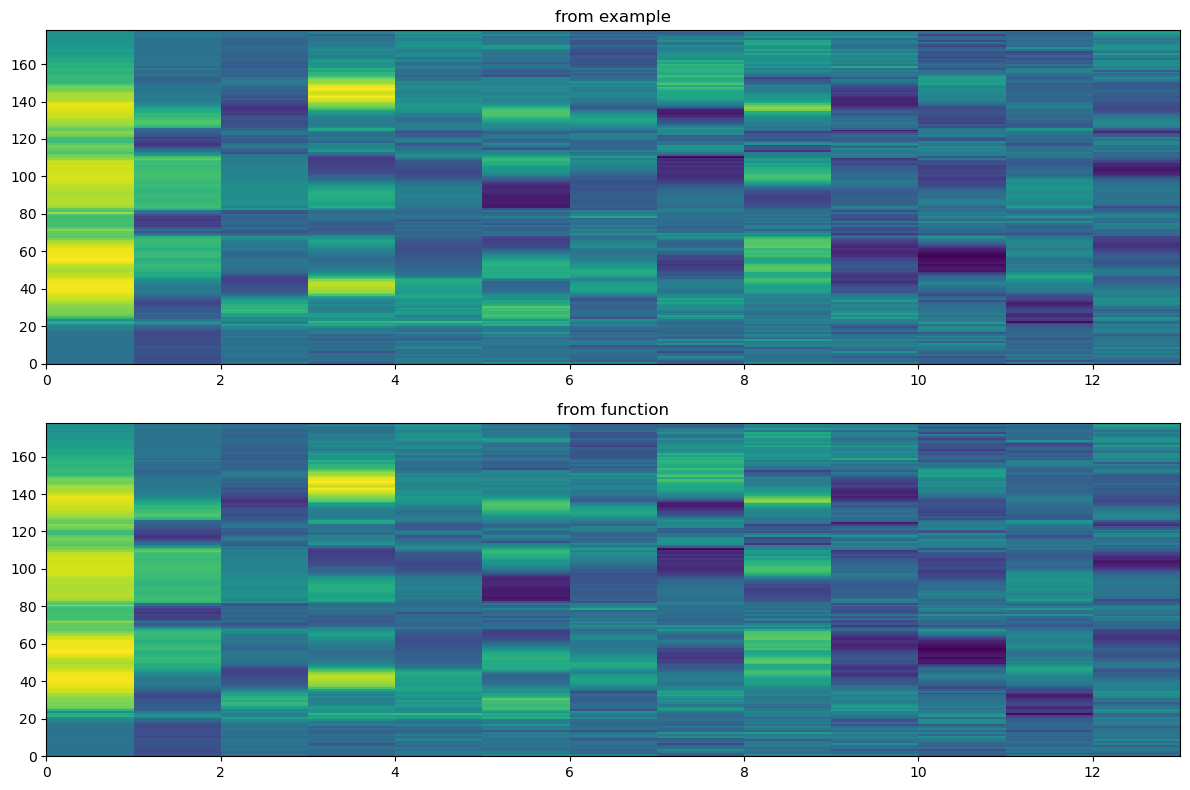

In [13]:
import matplotlib.pyplot as plt

def plot_comparison(example_, function_, title1="from example", title2="from function", figsize=(12, 8)):
    
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)
    plt.pcolormesh(example_, shading="auto")
    plt.title(title1)
    plt.subplot(2, 1, 2)
    plt.pcolormesh(function_, shading="auto")
    plt.title(title2)
    plt.tight_layout()
    plt.show()

plot_comparison(example['lmfcc'], lmfcc, title1="from example", title2="from function", figsize=(12, 8))

In [14]:
wordTrans = list(path2info(filename)[2])
wordTrans

['z', '4', '3']

In [15]:
prondict = {}
prondict['o'] = ['ow']
prondict['z'] = ['z', 'iy', 'r', 'ow']
prondict['1'] = ['w', 'ah', 'n']
prondict['2'] = ['t', 'uw']
prondict['3'] = ['th', 'r', 'iy']
prondict['4'] = ['f', 'ao', 'r']
prondict['5'] = ['f', 'ay', 'v']
prondict['6'] = ['s', 'ih', 'k', 's']
prondict['7'] = ['s', 'eh', 'v', 'ah', 'n']
prondict['8'] = ['ey', 't']
prondict['9'] = ['n', 'ay', 'n']

from lab3_proto import *
phoneTrans = words2phones(wordTrans, prondict)
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [16]:
def concatTwoHMMs(hmm1, hmm2):
   num_states_hmm1 = len(hmm1['startprob']) - 1
   num_states_hmm2 = len(hmm2['startprob']) - 1
   num_states_concat = num_states_hmm1 + num_states_hmm2 + 1

   transmat = np.zeros((num_states_concat, num_states_concat))
   startprob = np.zeros(num_states_concat)
   startprob[:num_states_hmm1] = hmm1['startprob'][:num_states_hmm1]
   startprob[num_states_hmm1:num_states_hmm1 + num_states_hmm2] = (
   hmm1['startprob'][num_states_hmm1] * hmm2['startprob'][:num_states_hmm2]
   )

   M = num_states_hmm1 +1
   transmat[:num_states_hmm1+1, :num_states_hmm1+1] = hmm1['transmat']
   transmat[num_states_hmm1:, num_states_hmm1:] = hmm2['transmat']
   transmat[:M-1, M-1:] = np.outer(hmm1['transmat'][:M-1, -1], hmm2['startprob'])
   # for i in range(num_states_hmm1):
   #       transmat[i, num_states_hmm1:num_states_hmm1 + num_states_hmm2+1] = (
   #             hmm1['transmat'][i, num_states_hmm1] * hmm2['startprob'][:num_states_hmm2+1]
   #          ) index is esay to mistake kewu!!!!

   means = np.concatenate((hmm1['means'], hmm2['means']), axis=0)
   covars = np.concatenate((hmm1['covars'], hmm2['covars']), axis=0)

   concatenated_hmm = {
      'startprob': startprob,
      'transmat': transmat,
      'means': means,
      'covars': covars
   }

   return concatenated_hmm



# already implemented, uses concatTwoHMMs()
def concatHMMs(hmmmodels, namelist):
    """ Concatenates HMM models in a left to right manner

    Args:
       hmmmodels: dictionary of models indexed by model name. 
       hmmmodels[name] is a dictionaries with the following keys:
           name: phonetic or word symbol corresponding to the model
           startprob: M+1 array with priori probability of state
           transmat: (M+1)x(M+1) transition matrix
           means: MxD array of mean vectors
           covars: MxD array of variances
       namelist: list of model names that we want to concatenate

    D is the dimension of the feature vectors
    M is the number of emitting states in each HMM model (could be
      different in each model)

    Output
       combinedhmm: dictionary with the same keys as the input but
                    combined models:
         startprob: K+1 array with priori probability of state
          transmat: (K+1)x(K+1) transition matrix
             means: KxD array of mean vectors
            covars: KxD array of variances

    K is the sum of the number of emitting states from the input models

    Example:
       wordHMMs['o'] = concatHMMs(phoneHMMs, ['sil', 'ow', 'sil'])
    """
    concat = hmmmodels[namelist[0]]
    for idx in range(1,len(namelist)):
        concat = concatTwoHMMs(concat, hmmmodels[namelist[idx]])
    return concat

In [17]:

utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

In [18]:
utteranceHMM['transmat']

array([[0.8833106 , 0.1166894 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9164465 , 0.08355348, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.802877  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9164465 , 0.08355348,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.802877  ,
        0.197123  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [19]:
example['utteranceHMM']['transmat']

array([[0.8833106 , 0.1166894 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.9164465 , 0.08355348, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.802877  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.9164465 , 0.08355348,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.802877  ,
        0.197123  ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [20]:
np.where(~np.isclose(utteranceHMM['transmat'], example['utteranceHMM']['transmat'], atol=1e-6))


(array([], dtype=int64), array([], dtype=int64))

In [21]:
np.allclose(utteranceHMM['transmat'], example['utteranceHMM']['transmat'])

True

In [22]:
utteranceHMM['startprob']

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

In [23]:
stateTrans = [phone + '_' + str(stateid)
    for phone in phoneTrans
    for stateid in range(nstates[phone])]
stateTrans[10]


'r_1'

In [24]:
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [25]:
len(stateTrans)

39

C:\Users\25954\AppData\Local\Temp\ipykernel_37832\2009378698.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\2009378698.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\2009378698.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\2009378698.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


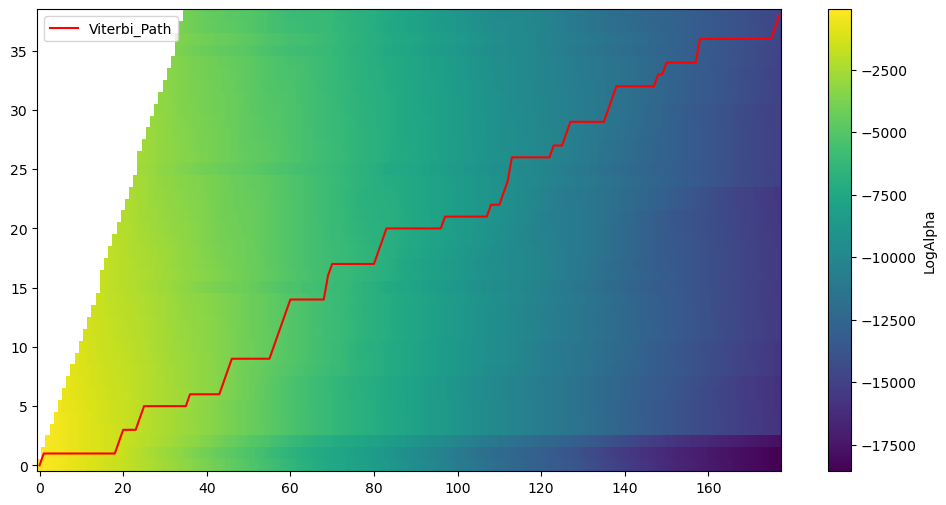

In [26]:
import sys
sys.path.append('../lab2')
from lab2_tools import *
from lab2_proto import *
import matplotlib.pyplot as plt
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])

# Viterbi Approximation
viterbi_loglik, viterbi_path = viterbi(
    obsloglik,
    np.log(utteranceHMM['startprob']),
    np.log(utteranceHMM['transmat']),
    forceFinalState=True
)

logalpha = forward(
    obsloglik,
    np.log(utteranceHMM['startprob']),
    np.log(utteranceHMM['transmat']),
)
plt.figure(figsize=(12, 6))
plt.imshow(logalpha.T, aspect='auto', origin='lower')
plt.colorbar(label='LogAlpha')
plt.plot(viterbi_path, 'r-', label='Viterbi_Path')
plt.legend()
plt.show()




In [27]:
viterbi_path

array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  3,  3,  3,  3,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  7,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 11, 12, 13, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 19, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 22, 22, 22, 23, 24, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 27, 27, 27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       30, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 34, 34, 34,
       34, 34, 34, 34, 34, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 37, 38])

In [28]:
np.allclose(example['viterbiPath'],viterbi_path)

True

In [29]:
statetrans_path = [stateTrans[i] for i in viterbi_path]
statetrans_path

['sil_0',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_1',
 'sil_2',
 'z_0',
 'z_0',
 'z_0',
 'z_0',
 'z_1',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'z_2',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_0',
 'iy_1',
 'iy_2',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'ow_0',
 'ow_1',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'ow_2',
 'f_0',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_1',
 'f_2',
 'ao_0',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_1',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'ao_2',
 'r_0',
 'r_0',
 'r_0',
 'r_1',
 'r_2',
 'th_0',


In [30]:
frames2trans(statetrans_path, outfilename='z43a.lab')

'0 0.01 sil_0\n0.01 0.19000000000000003 sil_1\n0.19000000000000003 0.20000000000000004 sil_2\n0.20000000000000004 0.24000000000000007 z_0\n0.24000000000000007 0.25000000000000006 z_1\n0.25000000000000006 0.36000000000000015 z_2\n0.36000000000000015 0.4400000000000002 iy_0\n0.4400000000000002 0.45000000000000023 iy_1\n0.45000000000000023 0.46000000000000024 iy_2\n0.46000000000000024 0.5600000000000003 r_0\n0.5600000000000003 0.5700000000000003 r_1\n0.5700000000000003 0.5800000000000003 r_2\n0.5800000000000003 0.5900000000000003 ow_0\n0.5900000000000003 0.6000000000000003 ow_1\n0.6000000000000003 0.6900000000000004 ow_2\n0.6900000000000004 0.7000000000000004 f_0\n0.7000000000000004 0.8100000000000005 f_1\n0.8100000000000005 0.8200000000000005 f_2\n0.8200000000000005 0.8300000000000005 ao_0\n0.8300000000000005 0.9700000000000006 ao_1\n0.9700000000000006 1.0800000000000007 ao_2\n1.0800000000000007 1.1100000000000008 r_0\n1.1100000000000008 1.1200000000000008 r_1\n1.1200000000000008 1.13000

In [40]:
def alignment(lmfcc,filename):
    wordTrans = list(path2info(filename)[2])
    phoneTrans = words2phones(wordTrans, prondict)
    utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
    obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
    

    viterbi_loglik, viterbi_path = viterbi(
        obsloglik,
        np.log(utteranceHMM['startprob']),
        np.log(utteranceHMM['transmat']),
        forceFinalState=True
    )
    stateTrans_ = [phone + '_' + str(stateid)
        for phone in phoneTrans
        for stateid in range(nstates[phone])]
    statetrans_path = [stateTrans_[i] for i in viterbi_path]
    targets = list(map(stateList.index, statetrans_path))

    return targets

In [41]:
filename

'tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'

In [42]:
targets = alignment(lmfcc,filename)

C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [43]:
statetrans_path_unpacked = [stateList[i] for i in targets]
statetrans_path_unpacked == statetrans_path

True

# Feature Extraction

In [44]:
import os
traindata = []
for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            samples, samplingrate = loadAudio(filename)
            lmfcc = mfcc(samples, winlen, winshift)
            mspec_f,_ = mspec(samples, winlen, winshift)
            targets = alignment(lmfcc, filename)
            wordTrans = list(path2info(filename)[2])
            traindata.append({'filename': filename, 'lmfcc': lmfcc,
 'mspec': mspec_f, 'targets': targets})

C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [45]:
np.savez('traindata.npz', traindata=traindata)

In [46]:
testdata = []

for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'):
    for file in files:
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            
            samples, samplingrate = loadAudio(filename)
            lmfcc = mfcc(samples, winlen, winshift)
            mspec_f, _ = mspec(samples, winlen, winshift)
            targets = alignment(lmfcc, filename)
            wordTrans = list(path2info(filename)[2])
            
            testdata.append({
                'filename': filename,
                'lmfcc': lmfcc,
                'mspec': mspec_f,
                'targets': targets,
                'word': wordTrans
            })

np.savez('testdata.npz', testdata=testdata)

C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['startprob']),
C:\Users\25954\AppData\Local\Temp\ipykernel_37832\1625770682.py:11: RuntimeWarning: divide by zero encountered in log
  np.log(utteranceHMM['transmat']),


In [47]:
traindata_all = np.load('traindata.npz', allow_pickle=True)['traindata']
print(traindata_all[0]['filename'])


tidigits/disc_4.1.1/tidigits/train\man\pd\1a.wav


In [ ]:
import numpy as np
import os
from collections import Counter

traindata_all = np.load('traindata.npz', allow_pickle=True)['traindata']
gender_counter = Counter()

for item in traindata_all:
    filename = item['filename']
    parts = os.path.normpath(filename).split(os.sep)
    gender = parts[-3]
    gender_counter[gender] += 1

print("Gender distribution in traindata:")
for gender, count in gender_counter.items():
    print(f"{gender}: {count} samples")
# almost same dont need to do stratification

Gender distribution in traindata:
man: 4235 samples
woman: 4388 samples


In [49]:
from collections import defaultdict
traindata_all = np.load('traindata.npz', allow_pickle=True)['traindata']
# based on speaker id
# division similar by gender
grouped_by_gender = defaultdict(list)
for item in traindata_all:
    filename = item['filename']
    parts = os.path.normpath(filename).split(os.sep)
    gender = parts[-3]
    speaker = parts[-2]
    grouped_by_gender[(gender, speaker)].append(item)

# Split each group into train and test sets
train_data = []
val_data = []
train_gender_count = Counter()
val_gender_count = Counter()
for (gender, speaker), items in grouped_by_gender.items():
    if np.random.rand() < 0.9:
        train_data.extend(items)
        train_gender_count[gender] += 1
    else:
        val_data.extend(items)
        val_gender_count[gender] += 1

np.savez('train.npz', X_train=train_data)
np.savez('val.npz', X_val=val_data)
print(f"Train size: {len(train_data)}, Val size: {len(val_data)}")
print("Train gender count:", train_gender_count)
print("Val gender count:", val_gender_count)


Train size: 7853, Val size: 770
Train gender count: Counter({'woman': 52, 'man': 50})
Val gender count: Counter({'man': 5, 'woman': 5})


# Acoustic Context (Dynamic Features)

In [50]:
def dynamic_features(data):
    def mirror_index(i, n_frames):
        if i < 0:
            return -i
        elif i >= n_frames:
            return 2 * n_frames - 2 - i # i+1 + x = 2*n_frames - 1
        else:
            return i

    D_lmfcc = data[0]['lmfcc'].shape[1]
    D_mspec = data[0]['mspec'].shape[1]
    N = sum([len(x['targets']) for x in data]) 
    mfcc_features = np.zeros((N, D_lmfcc * 7))
    mspec_features = np.zeros((N, D_mspec * 7))
    k =0 
    for x in data: 
        lmfcc = x['lmfcc']
        mspec = x['mspec']
        n_frames = lmfcc.shape[0]

        for i in range(n_frames):
            indices = [mirror_index(i + offset, n_frames) for offset in [-3, -2, -1, 0, 1, 2, 3]]
            mfcc_features[k, :] = np.hstack([lmfcc[j] for j in indices])
            mspec_features[k, :] = np.hstack([mspec[j] for j in indices])
            k+=1

    return mfcc_features, mspec_features

In [52]:
mfcc_train, mspec_train = dynamic_features(train_data)
targets_train = np.concatenate([x['targets'] for x in train_data])
mfcc_val, mspec_val = dynamic_features(val_data)
targets_val = np.concatenate([x['targets'] for x in val_data])
mfcc_test, mspec_test = dynamic_features(testdata)
targets_test = np.concatenate([x['targets'] for x in testdata])

In [53]:
np.savez('train_features.npz', mfcc=mfcc_train, mspec=mspec_train, targets=targets_train)
np.savez('val_features.npz', mfcc=mfcc_val, mspec=mspec_val, targets=targets_val)
np.savez('test_features.npz', mfcc=mfcc_test, mspec=mspec_test, targets=targets_test)

In [54]:
targets_test[0]

39

# Feature Standardisation

In [56]:
from sklearn.preprocessing import StandardScaler
import torch
scaler_mfcc = StandardScaler()
mfcc_train_x = scaler_mfcc.fit_transform(mfcc_train)
mfcc_val_x = scaler_mfcc.transform(mfcc_val)
mfcc_test_x = scaler_mfcc.transform(mfcc_test)

scaler_mspec = StandardScaler()
mspec_train_x = scaler_mspec.fit_transform(mspec_train)
mspec_val_x = scaler_mspec.transform(mspec_val)
mspec_test_x = scaler_mspec.transform(mspec_test)

mfcc_train_x = mfcc_train_x.astype('float32')
mfcc_val_x   = mfcc_val_x.astype('float32')
mfcc_test_x  = mfcc_test_x.astype('float32')

mspec_train_x = mspec_train_x.astype('float32')
mspec_val_x   = mspec_val_x.astype('float32')
mspec_test_x  = mspec_test_x.astype('float32')
import torch.nn.functional as F
output_dim = len(stateList)
train_y = F.one_hot(torch.tensor(targets_train).long(), num_classes=output_dim)
val_y   = F.one_hot(torch.tensor(targets_val).long(),   num_classes=output_dim)
test_y  = F.one_hot(torch.tensor(targets_test).long(),  num_classes=output_dim)

np.savez('lmfcc_train_x.npz', X=mfcc_train_x)
np.savez('lmfcc_val_x.npz', X=mfcc_val_x)
np.savez('lmfcc_test_x.npz', X=mfcc_test_x)

np.savez('mspec_train_x.npz', X=mspec_train_x)
np.savez('mspec_val_x.npz', X=mspec_val_x)
np.savez('mspec_test_x.npz', X=mspec_test_x)

np.savez('train_y.npz', y=targets_train)
np.savez('val_y.npz', y=targets_val)
np.savez('test_y.npz', y=targets_test)



In [57]:
print(targets_train[0])
print( train_y[0])

39
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


# DNN

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


input_dim = 91
hidden_dim = 256
output_dim = len(stateList)

# define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

# instantiate the network and print the structure
net = Net()
print(net)
print("Number of parameters:", count_parameters(net))

# define your loss criterion (see https://pytorch.org/docs/stable/nn.html#loss-functions)
criterion = nn.CrossEntropyLoss()

# define the optimizer 
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# prepare/load the data into tensors 
# train_x = ..., train_y = ..., val_x = ..., val_y = ..., test_x = ..., test_y = ...
train_x = torch.tensor(mfcc_train_x)
val_x   = torch.tensor(mfcc_val_x)
test_x  = torch.tensor(mfcc_test_x)
train_y_tensor = torch.tensor(targets_train).long()
val_y_tensor   = torch.tensor(targets_val).long()
test_y_tensor  = torch.tensor(targets_test).long()

batch_size = 256

# create the data loaders for training and validation sets
train_dataset = torch.utils.data.TensorDataset(train_x, train_y_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(val_x, val_y_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# setup logging so that you can follow training using TensorBoard (see https://pytorch.org/docs/stable/tensorboard.html)
writer = SummaryWriter()

# train the network
num_epochs = 100

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # accumulate the training loss
        train_loss += loss.item()* inputs.size(0)
    epoch_loss = train_loss / len(train_loader.dataset)

    # calculate the validation loss
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    

    # print the epoch loss
    val_loss = val_loss / len(val_loader.dataset)
    accuracy = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {accuracy:.4f}")
    writer.add_scalars('Loss', {'Train': epoch_loss, 'Validation': val_loss}, epoch)
    writer.add_scalar('Validation Accuracy', accuracy, epoch)

# finally evaluate model on the test set here
# ...

# save the trained network
torch.save(net.state_dict(), 'trained-net.pt')


Net(
  (fc1): Linear(in_features=91, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=61, bias=True)
)
Number of parameters: 39229
Epoch 1/100: Train Loss = 0.8617, Val Loss = 0.7774, Val Acc = 0.7436
Epoch 2/100: Train Loss = 0.7043, Val Loss = 0.7386, Val Acc = 0.7557
Epoch 3/100: Train Loss = 0.6725, Val Loss = 0.7264, Val Acc = 0.7607
Epoch 4/100: Train Loss = 0.6556, Val Loss = 0.7132, Val Acc = 0.7653
Epoch 5/100: Train Loss = 0.6441, Val Loss = 0.7103, Val Acc = 0.7659
Epoch 6/100: Train Loss = 0.6358, Val Loss = 0.7080, Val Acc = 0.7672
Epoch 7/100: Train Loss = 0.6294, Val Loss = 0.7118, Val Acc = 0.7635
Epoch 8/100: Train Loss = 0.6243, Val Loss = 0.7022, Val Acc = 0.7681
Epoch 9/100: Train Loss = 0.6202, Val Loss = 0.7176, Val Acc = 0.7632
Epoch 10/100: Train Loss = 0.6168, Val Loss = 0.6976, Val Acc = 0.7704
Epoch 11/100: Train Loss = 0.6133, Val Loss = 0.7004, Val Acc = 0.7688
Epoch 12/100: Train Loss = 0.6106, Val Loss = 0.6930, Val Acc = 0.7709
